In [1]:
import warnings
import sys
sys.path.insert(0, '../src')

In [2]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
from felix_ml_tools import macgyver as mg

In [4]:
from utils import *
import config

In [5]:
warnings.filterwarnings('ignore')

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline 

# Target Population

Para contextualizar a análise comparativa entre as cidades e facilitar o entendimento, foram aplicados os seguintes critérios para realizar um recorte nos dados:
- Considerar ano mais atual de cada base, devido a dificuldade de históricos mais recentes 
- Considerar apenas municípios do Nordeste, devido a semelhança regional (comportamento, dialeto, temperatura, clima, etc.)
- Considerar apenas homicídios de Jovens (15 a 29 anos), conforme desafio proposto
- Considerar uma única faixa de populacao, que possui a maior quantidade de cidades com maiores níveis de homicídios (> 60%)

## Target Users

- Ministério da Justiça e Segurança Pública
- Departamento de defesa e segurança estadual
- Secretaria da Segurança e da Defesa Social
- Igarapé

## Intro

Ingerindo alguns dados básicos. Considerando apenas o último snapshot (ou seja, ano em [de 2020, 2019, 2018]) para cada conjunto de dados

In [6]:
municipio = pd.read_parquet('../data/handled/ibge_municipio.parquet')
# municipio = municipio[(municipio['uf'].isin(UFS))]

inspect(municipio);

shape: (5570, 7)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,ALTA FLORESTA D OESTE,1100015,110001
1,RO,11,Rondônia,Ariquemes,ARIQUEMES,1100023,110002
2,RO,11,Rondônia,Cabixi,CABIXI,1100031,110003
3,RO,11,Rondônia,Cacoal,CACOAL,1100049,110004
4,RO,11,Rondônia,Cerejeiras,CEREJEIRAS,1100056,110005


In [7]:
municipio_pib = pd.read_parquet('../data/handled/ibge_municipio_pib.parquet')

print(municipio_pib['ano'].unique())

municipio_pib = (
    municipio_pib[
        # (municipio_pib['uf'].isin(UFS)) &
        (municipio_pib['ano'] == 2017)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_pib);

[2017]
shape: (5570, 17)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'municipioCodigo6d']


,uf,ufCodigo,nomeUf,nomeMunicipio,municipioCodigo,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,municipioCodigo6d
0,RO,11,Rondônia,Alta Floresta D'Oeste,1100015,169623,27805,117717,154926,470072,28793,498864,19612,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária",Demais serviços\r,110001
1,RO,11,Rondônia,Ariquemes,1100023,165217,330319,933935,634591,2064062,232012,2296074,21390,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,110002
2,RO,11,Rondônia,Cabixi,1100031,63022,4797,22431,43150,133399,5494,138894,22316,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária","Agricultura, inclusive apoio à agricultura e a...",110003
3,RO,11,Rondônia,Cacoal,1100049,255060,224595,908665,521368,1909689,217835,2127523,24038,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,110004
4,RO,11,Rondônia,Cerejeiras,1100056,61940,22170,192882,107819,384811,63713,448524,25010,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,110005


In [8]:
municipio_pib_atividades_relevantes = (
    municipio_pib
    .groupby('atividadeMaisRelevanteValorBruto1')
    .agg(count=('municipioCodigo', 'count'))
    .sort_values(by='count', ascending=False)
    .reset_index()
)

inspect(municipio_pib_atividades_relevantes);

shape: (10, 2)
columns: ['atividadeMaisRelevanteValorBruto1', 'count']


,atividadeMaisRelevanteValorBruto1,count
0,"Administração, defesa, educação e saúde públic...",2741
1,Demais serviços,1535
2,"Agricultura, inclusive apoio à agricultura e a...",652
3,Indústrias de transformação,279
4,"Pecuária, inclusive apoio à pecuária",126


In [9]:
municipio_funcionarios = pd.read_parquet('../data/handled/rais_caged_municipio_funcionarios.parquet')

print(municipio_funcionarios['ano'].sort_values().unique())

municipio_funcionarios = (
    municipio_funcionarios[
        # (municipio_funcionarios['uf'].isin(UFS)) &
        (municipio_funcionarios['ano'] == 2018)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_funcionarios);

[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020]
shape: (5502, 6)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'totalFuncionarios']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,totalFuncionarios
8,AC,12,Acrelândia,1200013,120001,598
19,AC,12,Assis Brasil,1200054,120005,265
30,AC,12,Brasiléia,1200104,120010,1952
41,AC,12,Bujari,1200138,120013,1155
52,AC,12,Capixaba,1200179,120017,411


In [10]:
municipio_populacao_estimada = pd.read_parquet('../data/handled/ibge_municipio_populacao_estimada.parquet')

print(municipio_populacao_estimada['ano'].sort_values().unique())

municipio_populacao_estimada = (
    municipio_populacao_estimada[
        # (municipio_populacao_estimada['uf'].isin(UFS)) & 
        (municipio_populacao_estimada['ano'] == 2020)
    ]
    .drop(columns=['ano'])
)

inspect(municipio_populacao_estimada);

[2020]
shape: (5570, 7)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'populacaoEstimada', 'municipioCodigo6d', 'faixaPopulacaoEstimada']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,populacaoEstimada,municipioCodigo6d,faixaPopulacaoEstimada
0,RO,11,Alta Floresta D'Oeste,1100015,22945.000,110001,20000:30000
1,RO,11,Ariquemes,1100023,107863.000,110002,80000:130000
2,RO,11,Cabixi,1100031,5312.000,110003,0:10000
3,RO,11,Cacoal,1100049,85359.000,110004,80000:130000
4,RO,11,Cerejeiras,1100056,16323.000,110005,10000:20000


In [11]:
# homicídios de jovens e adultos agregados por cidade
municipio_homicidios = pd.read_parquet('../data/handled/sim_municipio_homicidios.parquet')

print((municipio_homicidios['dtobito_year']).unique())

municipio_homicidios = (
    municipio_homicidios[
        # (municipio_homicidios['uf'].isin(UFS)) & 
        (municipio_homicidios['dtobito_year'] == 2018)
    ]
    .drop(columns=['dtobito_year'])
)

inspect(municipio_homicidios);

[2013 2014 2016 2017 2018 2015]
shape: (2677, 12)
columns: ['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d', 'qtHomicidios', 'qtHomicidiosFeminino', 'qtHomicidiosMasculino', 'qtHomicidiosComAssistmed', 'qtHomicidiosSemAssistmed', 'qtHomicidiosSemOcupacao', 'qtHomicidiosComOcupacao']


,uf,ufCodigo,nomeMunicipio,municipioCodigo,municipioCodigo6d,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao
4,AC,12,Acrelândia,1200013,120001,4,0,4,2,2,3,1
6,AC,12,Assis Brasil,1200054,120005,6,0,6,0,6,6,0
11,AC,12,Brasiléia,1200104,120010,5,0,5,0,5,5,0
20,AC,12,Capixaba,1200179,120017,3,0,3,0,3,3,0
26,AC,12,Cruzeiro do Sul,1200203,120020,34,1,33,10,24,20,14


In [12]:
# homicídios de jovens e adultos agregados por estado

estado_homicidios = (
    municipio_homicidios
    .groupby(['uf', 'ufCodigo'])
    .agg(
        ufQtHomicidios=('qtHomicidios', 'sum'),
        ufQtHomicidiosFeminino=('qtHomicidiosFeminino', 'sum'),
        ufQtHomicidiosMasculino=('qtHomicidiosMasculino', 'sum'),

        # TODO homicidios por racacor
        # TODO homicidios por lococor

        ufQtHomicidiosComAssistmed=('qtHomicidiosComAssistmed', 'sum'),
        ufQtHomicidiosSemAssistmed=('qtHomicidiosSemAssistmed', 'sum'),
        ufQtHomicidiosSemOcupacao=('qtHomicidiosSemOcupacao', 'sum'),
        ufQtHomicidiosComOcupacao=('qtHomicidiosComOcupacao', 'sum'),
    )
    .reset_index()
)

inspect(estado_homicidios);

shape: (27, 9)
columns: ['uf', 'ufCodigo', 'ufQtHomicidios', 'ufQtHomicidiosFeminino', 'ufQtHomicidiosMasculino', 'ufQtHomicidiosComAssistmed', 'ufQtHomicidiosSemAssistmed', 'ufQtHomicidiosSemOcupacao', 'ufQtHomicidiosComOcupacao']


,uf,ufCodigo,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao
0,AC,12,234,13,221,40,193,197,37
1,AL,27,833,25,808,61,747,507,326
2,AM,13,851,64,787,125,667,310,541
3,AP,16,217,6,211,47,160,131,86
4,BA,29,3501,176,3325,320,2920,1926,1575


## Combinando dados

Combinando informações de diferentes fontes de dados a nível de município, para o ano mais recente

In [13]:
municipio_features = (
    municipio
    .merge(municipio_populacao_estimada, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_pib, on=['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_funcionarios, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(municipio_homicidios, on=['uf', 'ufCodigo', 'nomeMunicipio', 'municipioCodigo', 'municipioCodigo6d'], how='left')
    .merge(estado_homicidios, on=['uf', 'ufCodigo'], how='left')
)

municipio_features['part_homicidios_uf'] = municipio_features['qtHomicidios'] / municipio_features['ufQtHomicidios']

municipio_features['part_homicidios_sem_ocupacao'] = municipio_features['qtHomicidiosSemOcupacao'] / municipio_features['qtHomicidios']
municipio_features['part_homicidios_com_ocupacao'] = municipio_features['qtHomicidiosComOcupacao'] / municipio_features['qtHomicidios']

municipio_features['part_funcionarios_populacao'] = municipio_features['totalFuncionarios'] / municipio_features['populacaoEstimada']
municipio_features['part_funcionarios_populacao1k'] = municipio_features['part_funcionarios_populacao'] * 1e3
municipio_features['part_funcionarios_populacao10k'] = municipio_features['part_funcionarios_populacao'] * 1e4
municipio_features['part_funcionarios_populacao100k'] = municipio_features['part_funcionarios_populacao'] * 1e5

municipio_features['part_homicidios_populacao'] = municipio_features['qtHomicidios'] / municipio_features['populacaoEstimada']
municipio_features['part_homicidios_populacao1k'] = municipio_features['part_homicidios_populacao'] * 1e3
municipio_features['part_homicidios_populacao10k'] = municipio_features['part_homicidios_populacao'] * 1e4
municipio_features['part_homicidios_populacao100k'] = municipio_features['part_homicidios_populacao'] * 1e5

inspect(municipio_features);

shape: (5570, 46)
columns: ['uf', 'ufCodigo', 'nomeUf', 'nomeMunicipio', 'nomeMunicipioNorm', 'municipioCodigo', 'municipioCodigo6d', 'populacaoEstimada', 'faixaPopulacaoEstimada', 'valorBrutoAgropecuraria1000', 'valorBrutoIndustria1000', 'valorBrutoServicos1000', 'valorBrutoUtilidade1000', 'valorBruto1000', 'impostosProdutos1000', 'pib1000', 'pibPerCapita', 'atividadeMaisRelevanteValorBruto1', 'atividadeMaisRelevanteValorBruto2', 'atividadeMaisRelevanteValorBruto3', 'totalFuncionarios', 'qtHomicidios', 'qtHomicidiosFeminino', 'qtHomicidiosMasculino', 'qtHomicidiosComAssistmed', 'qtHomicidiosSemAssistmed', 'qtHomicidiosSemOcupacao', 'qtHomicidiosComOcupacao', 'ufQtHomicidios', 'ufQtHomicidiosFeminino', 'ufQtHomicidiosMasculino', 'ufQtHomicidiosComAssistmed', 'ufQtHomicidiosSemAssistmed', 'ufQtHomicidiosSemOcupacao', 'ufQtHomicidiosComOcupacao', 'part_homicidios_uf', 'part_homicidios_sem_ocupacao', 'part_homicidios_com_ocupacao', 'part_funcionarios_populacao', 'part_funcionarios_populac

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k
0,RO,11,Rondônia,Alta Floresta D'Oeste,ALTA FLORESTA D OESTE,1100015,110001,22945.000,20000:30000,169623,27805,117717,154926,470072,28793,498864,19612,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária",Demais serviços\r,2145.000,1.000,0.000,1.000,0.000,1.000,1.000,0.000,181,15,166,40,139,87,94,0.006,1.000,0.000,0.093,93.484,934.844,9348.442,0.000,0.044,0.436,4.358
1,RO,11,Rondônia,Ariquemes,ARIQUEMES,1100023,110002,107863.000,80000:130000,165217,330319,933935,634591,2064062,232012,2296074,21390,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,15389.000,19.000,1.000,18.000,3.000,16.000,12.000,7.000,181,15,166,40,139,87,94,0.105,0.632,0.368,0.143,142.672,1426.717,14267.172,0.000,0.176,1.761,17.615
2,RO,11,Rondônia,Cabixi,CABIXI,1100031,110003,5312.000,0:10000,63022,4797,22431,43150,133399,5494,138894,22316,"Administração, defesa, educação e saúde públic...","Pecuária, inclusive apoio à pecuária","Agricultura, inclusive apoio à agricultura e a...",470.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,181,15,166,40,139,87,94,NaN,NaN,NaN,0.088,88.479,884.789,8847.892,NaN,NaN,NaN,NaN
3,RO,11,Rondônia,Cacoal,CACOAL,1100049,110004,85359.000,80000:130000,255060,224595,908665,521368,1909689,217835,2127523,24038,Demais serviços,"Administração, defesa, educação e saúde públic...",Comércio e reparação de veículos automotores e...,15088.000,9.000,1.000,8.000,2.000,7.000,3.000,6.000,181,15,166,40,139,87,94,0.050,0.333,0.667,0.177,176.759,1767.593,17675.933,0.000,0.105,1.054,10.544
4,RO,11,Rondônia,Cerejeiras,CEREJEIRAS,1100056,110005,16323.000,10000:20000,61940,22170,192882,107819,384811,63713,448524,25010,"Administração, defesa, educação e saúde públic...",Demais serviços,Comércio e reparação de veículos automotores e...,1877.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,181,15,166,40,139,87,94,0.006,0.000,1.000,0.115,114.991,1149.911,11499.112,0.000,0.061,0.613,6.126


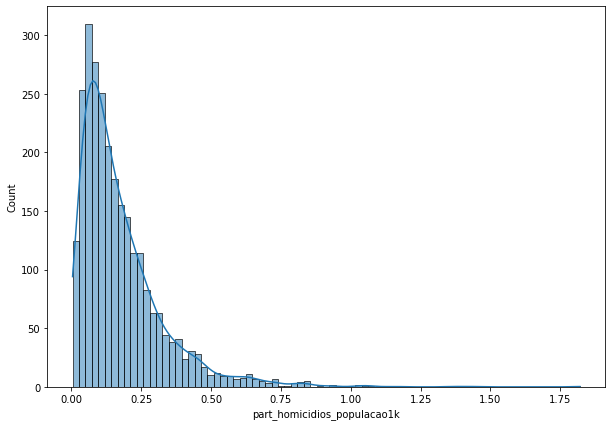

In [14]:
# categorizamos a taxa de homicidios por 1000 habitantes em 5 niveis, conforme distribuicao dos dados
municipio_features['nivelHomicidiosPopulacao1k'] = pd.cut(
    municipio_features['part_homicidios_populacao1k'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, np.inf],
    labels=['muito baixo', 'baixo', 'médio', 'alto', 'muito alto']
)

mg.plot_hist(municipio_features, 'part_homicidios_populacao1k')

## Recorte de dados

Selecionando apenas UFs do Nordeste, dado a semelhança regional (comportamento, dialeto, temperatura, clima, etc.)

In [15]:
municipio_features_slice = municipio_features[municipio_features['uf'].isin(config.target_ufs)]

municipio_features_slice.head()

,uf,ufCodigo,nomeUf,nomeMunicipio,nomeMunicipioNorm,municipioCodigo,municipioCodigo6d,populacaoEstimada,faixaPopulacaoEstimada,valorBrutoAgropecuraria1000,valorBrutoIndustria1000,valorBrutoServicos1000,valorBrutoUtilidade1000,valorBruto1000,impostosProdutos1000,pib1000,pibPerCapita,atividadeMaisRelevanteValorBruto1,atividadeMaisRelevanteValorBruto2,atividadeMaisRelevanteValorBruto3,totalFuncionarios,qtHomicidios,qtHomicidiosFeminino,qtHomicidiosMasculino,qtHomicidiosComAssistmed,qtHomicidiosSemAssistmed,qtHomicidiosSemOcupacao,qtHomicidiosComOcupacao,ufQtHomicidios,ufQtHomicidiosFeminino,ufQtHomicidiosMasculino,ufQtHomicidiosComAssistmed,ufQtHomicidiosSemAssistmed,ufQtHomicidiosSemOcupacao,ufQtHomicidiosComOcupacao,part_homicidios_uf,part_homicidios_sem_ocupacao,part_homicidios_com_ocupacao,part_funcionarios_populacao,part_funcionarios_populacao1k,part_funcionarios_populacao10k,part_funcionarios_populacao100k,part_homicidios_populacao,part_homicidios_populacao1k,part_homicidios_populacao10k,part_homicidios_populacao100k,nivelHomicidiosPopulacao1k
450,MA,21,Maranhão,Açailândia,ACAILANDIA,2100055,210005,112445.000,80000:130000,175271,706059,737604,385107,2004041,198246,2202287,19780,Indústrias de transformação,Demais serviços,"Administração, defesa, educação e saúde públic...",13164.000,14.000,1.000,13.000,2.000,12.000,8.000,6.000,889,39,850,257,606,343,546,0.016,0.571,0.429,0.117,117.071,1170.706,11707.057,0.000,0.125,1.245,12.451,muito baixo
451,MA,21,Maranhão,Afonso Cunha,AFONSO CUNHA,2100105,210010,6524.000,0:10000,10356,1834,9133,22418,43742,1236,44978,6935,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,240.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,0.037,36.787,367.872,3678.725,NaN,NaN,NaN,NaN,NaN
452,MA,21,Maranhão,Água Doce do Maranhão,GUA DOCE DO MARANHAO,2100154,210015,12571.000,10000:20000,7207,2849,19282,41452,70791,2654,73445,5896,"Administração, defesa, educação e saúde públic...",Demais serviços,"Agricultura, inclusive apoio à agricultura e a...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,889,39,850,257,606,343,546,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
453,MA,21,Maranhão,Alcântara,ALCANTARA,2100204,210020,22097.000,20000:30000,14385,7848,29653,59886,111772,4997,116770,5388,"Administração, defesa, educação e saúde públic...",Demais serviços,"Produção florestal, pesca e aquicultura",1517.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,889,39,850,257,606,343,546,0.001,0.000,1.000,0.069,68.652,686.519,6865.185,0.000,0.045,0.453,4.526,muito baixo
454,MA,21,Maranhão,Aldeias Altas,ALDEIAS ALTAS,2100303,210030,26532.000,20000:30000,38158,8576,37139,83659,167532,6996,174528,6614,"Administração, defesa, educação e saúde públic...","Agricultura, inclusive apoio à agricultura e a...",Demais serviços\r,1128.000,3.000,0.000,3.000,0.000,3.000,0.000,3.000,889,39,850,257,606,343,546,0.003,0.000,1.000,0.043,42.515,425.147,4251.470,0.000,0.113,1.131,11.307,muito baixo


Identificando faixa de população com maior quantidade de munípios com níveis altos de homocídios:

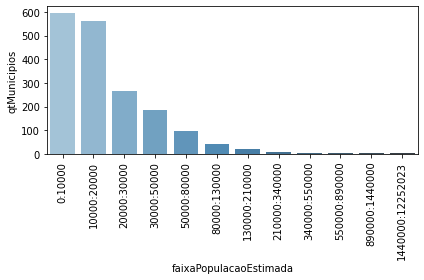

In [16]:
# Distribuição de cidades por faixa de população Estimada

qt_municipios_faixa_pop = (
    municipio_features_slice
    .groupby('faixaPopulacaoEstimada')
    .agg(qtMunicipios=('municipioCodigo', 'count'))
    .reset_index()
)

plot_bar(qt_municipios_faixa_pop, "faixaPopulacaoEstimada", "qtMunicipios")

municipios com alto nivel de homicidio por faixa de populacao


,faixaPopulacaoEstimada,qtMunicAltoNivelHomicidio,qtHomicidios,populacaoEstimada,qtMunicipios,part_homicidios_populacao1k,prop
0,0:10000,14,5.071,5897.071,594,0.860,0.024
1,10000:20000,12,9.667,14180.583,560,0.682,0.021
2,20000:30000,10,18.000,25210.300,264,0.714,0.038
3,30000:50000,4,33.750,37158.000,185,0.908,0.022
4,50000:80000,1,50.000,67337.000,96,0.743,0.010
5,80000:130000,4,64.750,98110.250,41,0.660,0.098
6,130000:210000,1,96.000,151596.000,20,0.633,0.050
7,210000:340000,0,NaN,NaN,10,NaN,0.000
8,340000:550000,0,NaN,NaN,6,NaN,0.000
9,550000:890000,0,NaN,NaN,6,NaN,0.000


faixa selecionada 0:10000


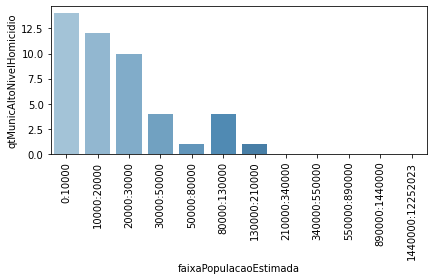

In [17]:
faixa_populacao_alto_nivel_homicidio = (
    municipio_features_slice[municipio_features_slice['nivelHomicidiosPopulacao1k'].isin(['alto', 'muito alto'])]
    .groupby(['faixaPopulacaoEstimada'])
    .agg(
        qtMunicAltoNivelHomicidio=('municipioCodigo', 'count'),
        qtHomicidios=('qtHomicidios', 'sum'),
        populacaoEstimada=('populacaoEstimada', 'sum'),
    )
    .reset_index()
    .merge(qt_municipios_faixa_pop, on=['faixaPopulacaoEstimada'])
    .assign(part_homicidios_populacao1k=lambda x: (x['qtHomicidios'] / x['populacaoEstimada']) * 1000)
    .assign(qtHomicidios=lambda x: (x['qtHomicidios'] / x['qtMunicAltoNivelHomicidio']))
    .assign(populacaoEstimada=lambda x: (x['populacaoEstimada'] / x['qtMunicAltoNivelHomicidio']))
    .assign(prop=lambda x: (x['qtMunicAltoNivelHomicidio'] / x['qtMunicipios']))
)

max_faixa_populacao_alto_nivel_homicidio = faixa_populacao_alto_nivel_homicidio.sort_values(by='qtMunicAltoNivelHomicidio', ascending=False).iloc[0]['faixaPopulacaoEstimada']

print('municipios com alto nivel de homicidio por faixa de populacao')
display(faixa_populacao_alto_nivel_homicidio)

print('faixa selecionada', max_faixa_populacao_alto_nivel_homicidio)

# recorte de municipios conforme faixa de populacao selecionada
municipio_features_slice = municipio_features_slice[municipio_features_slice['faixaPopulacaoEstimada'] == max_faixa_populacao_alto_nivel_homicidio]

plot_bar(faixa_populacao_alto_nivel_homicidio, "faixaPopulacaoEstimada", "qtMunicAltoNivelHomicidio")

- A maioria das cidades com nível de homicídio (por 1k hab.) alto ou muito estão na faixa de popoulação entre 0 e 10.000

## Salvando Dados

In [18]:
data_names = {
    'municipio_features': municipio_features,
    'municipio_features_slice': municipio_features_slice,
}

for name, df in data_names.items():
    df.to_parquet(f'../data/handled/{name}.parquet')